# Environment

In [4]:
import random

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import ImageFont
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

from utils.str_utils import get_common_hanzi
from utils.utils import convert_char_to_image

In [5]:
%cd ..

D:\Projects\PythonProjects\csc


# Datasets

In [6]:
class HanziImageDataset(Dataset):

    def __init__(self):
        super(HanziImageDataset, self).__init__()

        self.hanzi_list = list(get_common_hanzi())
        random.shuffle(self.hanzi_list)

        self.hanzi_image_cache = {}

    def __getitem__(self, index):
        hanzi = self.hanzi_list[index]
        if hanzi in self.hanzi_image_cache.keys():
            return self.hanzi_image_cache[hanzi]

        hanzi_image = convert_char_to_image(hanzi) / 255.
        self.hanzi_image_cache[hanzi] = hanzi_image
        return hanzi_image

    def __len__(self):
        return len(self.hanzi_list)

In [7]:
dataset = HanziImageDataset()

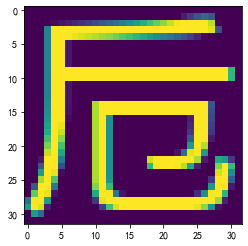

In [8]:
plt.imshow(dataset.__getitem__(0))

In [9]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model

In [10]:
class DenseAutoEncoder(nn.Module):
    # Loss: 0.0561

    def __init__(self):
        super(DenseAutoEncoder, self).__init__()
        self.encoder =  nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 56),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(56, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.Sigmoid()
        )

    def forward(self, images):
        bs = images.size(0)
        images = images.view(bs, -1)
        return self.decoder(self.encoder(images)).view(bs, 32, 32)

In [11]:
class ConvAutoEncoder(nn.Module):
    # Loss: 0.0712

    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder =  nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1),
            nn.Sigmoid(),
            nn.Flatten(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.Sigmoid()
        )

    def forward(self, images):
        bs = images.size(0)
        hidden_state = self.encoder(images.unsqueeze(1))
        return self.decoder(hidden_state.view(bs, -1)).view(bs, 32, 32)

In [12]:
model = DenseAutoEncoder()
# model = ConvAutoEncoder()

# Train

In [25]:
loss_fnt = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [26]:
epochs = 300

model = model.train()
for epoch in range(epochs):
    progress = tqdm(dataloader, desc="Epoch %s" % epoch)
    total_loss = 0.
    step = 0
    for images_X in progress:
        bs = images_X.size(0)
        images_Y = model(images_X)

        images_X = images_X.view(bs, -1)
        images_Y = images_Y.view(bs, -1)

        loss = loss_fnt(images_Y, images_X)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        step += 1

        progress.set_postfix({
            "loss": total_loss / step
        })
    print("lr:", optimizer.param_groups[0]['lr'])
    lr_scheduler.step()

Epoch 0: 100%|██████████| 106/106 [00:01<00:00, 78.54it/s, loss=0.136]


lr: 0.0003


Epoch 1: 100%|██████████| 106/106 [00:01<00:00, 80.80it/s, loss=0.13]


lr: 0.00029699999999999996


Epoch 2: 100%|██████████| 106/106 [00:01<00:00, 79.57it/s, loss=0.128]


lr: 0.00029403


Epoch 3: 100%|██████████| 106/106 [00:01<00:00, 81.65it/s, loss=0.125]


lr: 0.0002910897


Epoch 4: 100%|██████████| 106/106 [00:01<00:00, 81.36it/s, loss=0.123]


lr: 0.000288178803


Epoch 5: 100%|██████████| 106/106 [00:01<00:00, 80.01it/s, loss=0.12]


lr: 0.00028529701496999996


Epoch 6: 100%|██████████| 106/106 [00:01<00:00, 78.14it/s, loss=0.118]


lr: 0.00028244404482029995


Epoch 7: 100%|██████████| 106/106 [00:01<00:00, 76.04it/s, loss=0.116]


lr: 0.00027961960437209696


Epoch 8: 100%|██████████| 106/106 [00:01<00:00, 75.71it/s, loss=0.114]


lr: 0.000276823408328376


Epoch 9: 100%|██████████| 106/106 [00:01<00:00, 71.86it/s, loss=0.112]


lr: 0.0002740551742450922


Epoch 10: 100%|██████████| 106/106 [00:01<00:00, 70.83it/s, loss=0.11]


lr: 0.00027131462250264127


Epoch 11: 100%|██████████| 106/106 [00:01<00:00, 71.82it/s, loss=0.109]


lr: 0.0002686014762776149


Epoch 12: 100%|██████████| 106/106 [00:01<00:00, 72.01it/s, loss=0.107]


lr: 0.00026591546151483875


Epoch 13: 100%|██████████| 106/106 [00:01<00:00, 70.57it/s, loss=0.106]


lr: 0.00026325630689969036


Epoch 14: 100%|██████████| 106/106 [00:01<00:00, 69.27it/s, loss=0.105]


lr: 0.00026062374383069347


Epoch 15: 100%|██████████| 106/106 [00:01<00:00, 70.76it/s, loss=0.103]


lr: 0.00025801750639238655


Epoch 16: 100%|██████████| 106/106 [00:01<00:00, 70.30it/s, loss=0.102]


lr: 0.0002554373313284627


Epoch 17: 100%|██████████| 106/106 [00:01<00:00, 69.78it/s, loss=0.1] 


lr: 0.00025288295801517805


Epoch 18: 100%|██████████| 106/106 [00:01<00:00, 67.94it/s, loss=0.099]


lr: 0.0002503541284350263


Epoch 19: 100%|██████████| 106/106 [00:01<00:00, 68.75it/s, loss=0.0979]


lr: 0.00024785058715067604


Epoch 20: 100%|██████████| 106/106 [00:01<00:00, 67.93it/s, loss=0.0968]


lr: 0.00024537208127916926


Epoch 21: 100%|██████████| 106/106 [00:01<00:00, 68.19it/s, loss=0.0958]


lr: 0.00024291836046637757


Epoch 22: 100%|██████████| 106/106 [00:01<00:00, 67.74it/s, loss=0.0948]


lr: 0.00024048917686171379


Epoch 23: 100%|██████████| 106/106 [00:01<00:00, 67.14it/s, loss=0.0938]


lr: 0.00023808428509309665


Epoch 24: 100%|██████████| 106/106 [00:01<00:00, 65.98it/s, loss=0.0928]


lr: 0.0002357034422421657


Epoch 25: 100%|██████████| 106/106 [00:01<00:00, 66.63it/s, loss=0.0919]


lr: 0.00023334640781974404


Epoch 26: 100%|██████████| 106/106 [00:01<00:00, 66.48it/s, loss=0.0912]


lr: 0.00023101294374154658


Epoch 27: 100%|██████████| 106/106 [00:01<00:00, 65.78it/s, loss=0.0904]


lr: 0.0002287028143041311


Epoch 28: 100%|██████████| 106/106 [00:01<00:00, 65.13it/s, loss=0.0896]


lr: 0.00022641578616108978


Epoch 29: 100%|██████████| 106/106 [00:01<00:00, 66.32it/s, loss=0.0888]


lr: 0.00022415162829947887


Epoch 30: 100%|██████████| 106/106 [00:01<00:00, 65.89it/s, loss=0.0881]


lr: 0.00022191011201648408


Epoch 31: 100%|██████████| 106/106 [00:01<00:00, 65.32it/s, loss=0.0873]


lr: 0.00021969101089631924


Epoch 32: 100%|██████████| 106/106 [00:01<00:00, 65.52it/s, loss=0.0866]


lr: 0.00021749410078735604


Epoch 33: 100%|██████████| 106/106 [00:01<00:00, 66.16it/s, loss=0.0859]


lr: 0.00021531915977948248


Epoch 34: 100%|██████████| 106/106 [00:01<00:00, 65.41it/s, loss=0.0853]


lr: 0.00021316596818168765


Epoch 35: 100%|██████████| 106/106 [00:01<00:00, 65.95it/s, loss=0.0847]


lr: 0.00021103430849987078


Epoch 36: 100%|██████████| 106/106 [00:01<00:00, 65.32it/s, loss=0.0841]


lr: 0.00020892396541487206


Epoch 37: 100%|██████████| 106/106 [00:01<00:00, 65.97it/s, loss=0.0835]


lr: 0.00020683472576072333


Epoch 38: 100%|██████████| 106/106 [00:01<00:00, 65.35it/s, loss=0.0829]


lr: 0.0002047663785031161


Epoch 39: 100%|██████████| 106/106 [00:01<00:00, 65.55it/s, loss=0.0823]


lr: 0.00020271871471808493


Epoch 40: 100%|██████████| 106/106 [00:01<00:00, 65.47it/s, loss=0.0818]


lr: 0.00020069152757090408


Epoch 41: 100%|██████████| 106/106 [00:01<00:00, 64.50it/s, loss=0.0813]


lr: 0.00019868461229519504


Epoch 42: 100%|██████████| 106/106 [00:01<00:00, 64.86it/s, loss=0.0809]


lr: 0.0001966977661722431


Epoch 43: 100%|██████████| 106/106 [00:01<00:00, 64.44it/s, loss=0.0804]


lr: 0.00019473078851052066


Epoch 44: 100%|██████████| 106/106 [00:01<00:00, 65.33it/s, loss=0.08] 


lr: 0.00019278348062541544


Epoch 45: 100%|██████████| 106/106 [00:01<00:00, 65.03it/s, loss=0.0795]


lr: 0.00019085564581916128


Epoch 46: 100%|██████████| 106/106 [00:01<00:00, 64.51it/s, loss=0.0791]


lr: 0.00018894708936096965


Epoch 47: 100%|██████████| 106/106 [00:01<00:00, 64.89it/s, loss=0.0787]


lr: 0.00018705761846735995


Epoch 48: 100%|██████████| 106/106 [00:01<00:00, 65.42it/s, loss=0.0783]


lr: 0.00018518704228268635


Epoch 49: 100%|██████████| 106/106 [00:01<00:00, 63.14it/s, loss=0.0778]


lr: 0.00018333517185985948


Epoch 50: 100%|██████████| 106/106 [00:01<00:00, 64.97it/s, loss=0.0774]


lr: 0.00018150182014126088


Epoch 51: 100%|██████████| 106/106 [00:01<00:00, 64.77it/s, loss=0.077] 


lr: 0.00017968680193984827


Epoch 52: 100%|██████████| 106/106 [00:01<00:00, 64.58it/s, loss=0.0766]


lr: 0.0001778899339204498


Epoch 53: 100%|██████████| 106/106 [00:01<00:00, 64.46it/s, loss=0.0762]


lr: 0.0001761110345812453


Epoch 54: 100%|██████████| 106/106 [00:01<00:00, 64.13it/s, loss=0.0758]


lr: 0.00017434992423543284


Epoch 55: 100%|██████████| 106/106 [00:01<00:00, 64.42it/s, loss=0.0754]


lr: 0.0001726064249930785


Epoch 56: 100%|██████████| 106/106 [00:01<00:00, 64.01it/s, loss=0.0751]


lr: 0.00017088036074314772


Epoch 57: 100%|██████████| 106/106 [00:01<00:00, 64.16it/s, loss=0.0747]


lr: 0.00016917155713571625


Epoch 58: 100%|██████████| 106/106 [00:01<00:00, 64.53it/s, loss=0.0744]


lr: 0.00016747984156435908


Epoch 59: 100%|██████████| 106/106 [00:01<00:00, 64.37it/s, loss=0.074]


lr: 0.0001658050431487155


Epoch 60: 100%|██████████| 106/106 [00:01<00:00, 64.90it/s, loss=0.0737]


lr: 0.00016414699271722832


Epoch 61: 100%|██████████| 106/106 [00:01<00:00, 64.23it/s, loss=0.0734]


lr: 0.00016250552279005603


Epoch 62: 100%|██████████| 106/106 [00:01<00:00, 64.53it/s, loss=0.0731]


lr: 0.00016088046756215546


Epoch 63: 100%|██████████| 106/106 [00:01<00:00, 64.63it/s, loss=0.0728]


lr: 0.0001592716628865339


Epoch 64: 100%|██████████| 106/106 [00:01<00:00, 63.70it/s, loss=0.0725]


lr: 0.00015767894625766857


Epoch 65: 100%|██████████| 106/106 [00:01<00:00, 64.19it/s, loss=0.0722]


lr: 0.0001561021567950919


Epoch 66: 100%|██████████| 106/106 [00:01<00:00, 63.76it/s, loss=0.0719]


lr: 0.00015454113522714096


Epoch 67: 100%|██████████| 106/106 [00:01<00:00, 63.74it/s, loss=0.0717]


lr: 0.00015299572387486956


Epoch 68: 100%|██████████| 106/106 [00:01<00:00, 63.78it/s, loss=0.0714]


lr: 0.00015146576663612087


Epoch 69: 100%|██████████| 106/106 [00:01<00:00, 64.40it/s, loss=0.0712]


lr: 0.00014995110896975965


Epoch 70: 100%|██████████| 106/106 [00:01<00:00, 64.12it/s, loss=0.0709]


lr: 0.00014845159788006205


Epoch 71: 100%|██████████| 106/106 [00:01<00:00, 63.83it/s, loss=0.0707]


lr: 0.00014696708190126143


Epoch 72: 100%|██████████| 106/106 [00:01<00:00, 63.36it/s, loss=0.0704]


lr: 0.0001454974110822488


Epoch 73: 100%|██████████| 106/106 [00:01<00:00, 64.48it/s, loss=0.0702]


lr: 0.00014404243697142632


Epoch 74: 100%|██████████| 106/106 [00:01<00:00, 63.74it/s, loss=0.07]  


lr: 0.00014260201260171205


Epoch 75: 100%|██████████| 106/106 [00:01<00:00, 63.67it/s, loss=0.0698]


lr: 0.00014117599247569492


Epoch 76: 100%|██████████| 106/106 [00:01<00:00, 63.40it/s, loss=0.0696]


lr: 0.00013976423255093796


Epoch 77: 100%|██████████| 106/106 [00:01<00:00, 63.11it/s, loss=0.0694]


lr: 0.00013836659022542857


Epoch 78: 100%|██████████| 106/106 [00:01<00:00, 63.80it/s, loss=0.0692]


lr: 0.0001369829243231743


Epoch 79: 100%|██████████| 106/106 [00:01<00:00, 64.34it/s, loss=0.069]


lr: 0.00013561309507994257


Epoch 80: 100%|██████████| 106/106 [00:01<00:00, 63.80it/s, loss=0.0688]


lr: 0.00013425696412914314


Epoch 81: 100%|██████████| 106/106 [00:01<00:00, 62.36it/s, loss=0.0686]


lr: 0.0001329143944878517


Epoch 82: 100%|██████████| 106/106 [00:01<00:00, 64.10it/s, loss=0.0684]


lr: 0.0001315852505429732


Epoch 83: 100%|██████████| 106/106 [00:01<00:00, 64.53it/s, loss=0.0682]


lr: 0.00013026939803754346


Epoch 84: 100%|██████████| 106/106 [00:01<00:00, 64.20it/s, loss=0.068]


lr: 0.00012896670405716803


Epoch 85: 100%|██████████| 106/106 [00:01<00:00, 60.57it/s, loss=0.0678]


lr: 0.00012767703701659636


Epoch 86: 100%|██████████| 106/106 [00:01<00:00, 61.25it/s, loss=0.0676]


lr: 0.0001264002666464304


Epoch 87: 100%|██████████| 106/106 [00:01<00:00, 63.67it/s, loss=0.0675]


lr: 0.0001251362639799661


Epoch 88: 100%|██████████| 106/106 [00:01<00:00, 63.20it/s, loss=0.0673]


lr: 0.00012388490134016643


Epoch 89: 100%|██████████| 106/106 [00:01<00:00, 63.74it/s, loss=0.0671]


lr: 0.00012264605232676477


Epoch 90: 100%|██████████| 106/106 [00:01<00:00, 64.02it/s, loss=0.067] 


lr: 0.00012141959180349711


Epoch 91: 100%|██████████| 106/106 [00:01<00:00, 63.61it/s, loss=0.0668]


lr: 0.00012020539588546214


Epoch 92: 100%|██████████| 106/106 [00:01<00:00, 64.02it/s, loss=0.0666]


lr: 0.00011900334192660752


Epoch 93: 100%|██████████| 106/106 [00:01<00:00, 63.30it/s, loss=0.0664]


lr: 0.00011781330850734145


Epoch 94: 100%|██████████| 106/106 [00:01<00:00, 63.32it/s, loss=0.0663]


lr: 0.00011663517542226803


Epoch 95: 100%|██████████| 106/106 [00:01<00:00, 63.44it/s, loss=0.0661]


lr: 0.00011546882366804535


Epoch 96: 100%|██████████| 106/106 [00:01<00:00, 63.50it/s, loss=0.066]


lr: 0.0001143141354313649


Epoch 97: 100%|██████████| 106/106 [00:01<00:00, 63.51it/s, loss=0.0658]


lr: 0.00011317099407705124


Epoch 98: 100%|██████████| 106/106 [00:01<00:00, 63.71it/s, loss=0.0656]


lr: 0.00011203928413628072


Epoch 99: 100%|██████████| 106/106 [00:01<00:00, 63.27it/s, loss=0.0655]


lr: 0.00011091889129491791


Epoch 100: 100%|██████████| 106/106 [00:01<00:00, 63.22it/s, loss=0.0654]


lr: 0.00010980970238196873


Epoch 101: 100%|██████████| 106/106 [00:01<00:00, 63.36it/s, loss=0.0652]


lr: 0.00010871160535814904


Epoch 102: 100%|██████████| 106/106 [00:01<00:00, 63.44it/s, loss=0.0651]


lr: 0.00010762448930456754


Epoch 103: 100%|██████████| 106/106 [00:01<00:00, 63.62it/s, loss=0.0649]


lr: 0.00010654824441152186


Epoch 104: 100%|██████████| 106/106 [00:01<00:00, 63.65it/s, loss=0.0648]


lr: 0.00010548276196740664


Epoch 105: 100%|██████████| 106/106 [00:01<00:00, 61.95it/s, loss=0.0647]


lr: 0.00010442793434773257


Epoch 106: 100%|██████████| 106/106 [00:01<00:00, 60.57it/s, loss=0.0645]


lr: 0.00010338365500425524


Epoch 107: 100%|██████████| 106/106 [00:01<00:00, 60.46it/s, loss=0.0644]


lr: 0.0001023498184542127


Epoch 108: 100%|██████████| 106/106 [00:01<00:00, 59.42it/s, loss=0.0643]


lr: 0.00010132632026967056


Epoch 109: 100%|██████████| 106/106 [00:01<00:00, 59.68it/s, loss=0.0642]


lr: 0.00010031305706697385


Epoch 110: 100%|██████████| 106/106 [00:01<00:00, 59.76it/s, loss=0.0641]


lr: 9.930992649630411e-05


Epoch 111: 100%|██████████| 106/106 [00:01<00:00, 63.79it/s, loss=0.0639]


lr: 9.831682723134107e-05


Epoch 112: 100%|██████████| 106/106 [00:01<00:00, 63.87it/s, loss=0.0638]


lr: 9.733365895902766e-05


Epoch 113: 100%|██████████| 106/106 [00:01<00:00, 63.54it/s, loss=0.0637]


lr: 9.636032236943738e-05


Epoch 114: 100%|██████████| 106/106 [00:01<00:00, 63.44it/s, loss=0.0636]


lr: 9.5396719145743e-05


Epoch 115: 100%|██████████| 106/106 [00:01<00:00, 63.87it/s, loss=0.0634]


lr: 9.444275195428557e-05


Epoch 116: 100%|██████████| 106/106 [00:01<00:00, 63.17it/s, loss=0.0633]


lr: 9.349832443474271e-05


Epoch 117: 100%|██████████| 106/106 [00:01<00:00, 63.61it/s, loss=0.0632]


lr: 9.256334119039527e-05


Epoch 118: 100%|██████████| 106/106 [00:01<00:00, 63.56it/s, loss=0.0631]


lr: 9.163770777849132e-05


Epoch 119: 100%|██████████| 106/106 [00:01<00:00, 63.33it/s, loss=0.063] 


lr: 9.07213307007064e-05


Epoch 120: 100%|██████████| 106/106 [00:01<00:00, 63.62it/s, loss=0.0629]


lr: 8.981411739369934e-05


Epoch 121: 100%|██████████| 106/106 [00:01<00:00, 62.23it/s, loss=0.0628]


lr: 8.891597621976235e-05


Epoch 122: 100%|██████████| 106/106 [00:01<00:00, 63.16it/s, loss=0.0627]


lr: 8.802681645756472e-05


Epoch 123: 100%|██████████| 106/106 [00:01<00:00, 63.26it/s, loss=0.0626]


lr: 8.714654829298908e-05


Epoch 124: 100%|██████████| 106/106 [00:01<00:00, 63.36it/s, loss=0.0625]


lr: 8.627508281005918e-05


Epoch 125: 100%|██████████| 106/106 [00:01<00:00, 63.49it/s, loss=0.0625]


lr: 8.54123319819586e-05


Epoch 126: 100%|██████████| 106/106 [00:01<00:00, 63.71it/s, loss=0.0623]


lr: 8.455820866213901e-05


Epoch 127: 100%|██████████| 106/106 [00:01<00:00, 63.24it/s, loss=0.0622]


lr: 8.371262657551763e-05


Epoch 128: 100%|██████████| 106/106 [00:01<00:00, 62.65it/s, loss=0.0622]


lr: 8.287550030976245e-05


Epoch 129: 100%|██████████| 106/106 [00:01<00:00, 61.59it/s, loss=0.0621]


lr: 8.204674530666482e-05


Epoch 130: 100%|██████████| 106/106 [00:01<00:00, 62.98it/s, loss=0.062]


lr: 8.122627785359817e-05


Epoch 131: 100%|██████████| 106/106 [00:01<00:00, 63.22it/s, loss=0.0619]


lr: 8.041401507506219e-05


Epoch 132: 100%|██████████| 106/106 [00:01<00:00, 62.86it/s, loss=0.0618]


lr: 7.960987492431156e-05


Epoch 133: 100%|██████████| 106/106 [00:01<00:00, 63.10it/s, loss=0.0617]


lr: 7.881377617506845e-05


Epoch 134: 100%|██████████| 106/106 [00:01<00:00, 62.42it/s, loss=0.0617]


lr: 7.802563841331776e-05


Epoch 135: 100%|██████████| 106/106 [00:01<00:00, 62.73it/s, loss=0.0616]


lr: 7.724538202918458e-05


Epoch 136: 100%|██████████| 106/106 [00:01<00:00, 63.13it/s, loss=0.0615]


lr: 7.647292820889273e-05


Epoch 137: 100%|██████████| 106/106 [00:01<00:00, 62.90it/s, loss=0.0614]


lr: 7.570819892680381e-05


Epoch 138: 100%|██████████| 106/106 [00:01<00:00, 62.85it/s, loss=0.0614]


lr: 7.495111693753577e-05


Epoch 139: 100%|██████████| 106/106 [00:01<00:00, 63.16it/s, loss=0.0613]


lr: 7.420160576816041e-05


Epoch 140: 100%|██████████| 106/106 [00:01<00:00, 63.14it/s, loss=0.0612]


lr: 7.34595897104788e-05


Epoch 141: 100%|██████████| 106/106 [00:01<00:00, 62.65it/s, loss=0.0611]


lr: 7.272499381337402e-05


Epoch 142: 100%|██████████| 106/106 [00:01<00:00, 62.69it/s, loss=0.061]


lr: 7.199774387524028e-05


Epoch 143: 100%|██████████| 106/106 [00:01<00:00, 63.03it/s, loss=0.061] 


lr: 7.127776643648787e-05


Epoch 144: 100%|██████████| 106/106 [00:01<00:00, 62.53it/s, loss=0.0609]


lr: 7.0564988772123e-05


Epoch 145: 100%|██████████| 106/106 [00:01<00:00, 62.68it/s, loss=0.0609]


lr: 6.985933888440177e-05


Epoch 146: 100%|██████████| 106/106 [00:01<00:00, 63.36it/s, loss=0.0607]


lr: 6.916074549555775e-05


Epoch 147: 100%|██████████| 106/106 [00:01<00:00, 62.44it/s, loss=0.0607]


lr: 6.846913804060217e-05


Epoch 148: 100%|██████████| 106/106 [00:01<00:00, 62.92it/s, loss=0.0606]


lr: 6.778444666019615e-05


Epoch 149: 100%|██████████| 106/106 [00:01<00:00, 63.52it/s, loss=0.0606]


lr: 6.710660219359419e-05


Epoch 150: 100%|██████████| 106/106 [00:01<00:00, 62.52it/s, loss=0.0605]


lr: 6.643553617165824e-05


Epoch 151: 100%|██████████| 106/106 [00:01<00:00, 62.48it/s, loss=0.0605]


lr: 6.577118080994166e-05


Epoch 152: 100%|██████████| 106/106 [00:01<00:00, 62.02it/s, loss=0.0604]


lr: 6.511346900184224e-05


Epoch 153: 100%|██████████| 106/106 [00:01<00:00, 62.66it/s, loss=0.0603]


lr: 6.446233431182382e-05


Epoch 154: 100%|██████████| 106/106 [00:01<00:00, 62.72it/s, loss=0.0602]


lr: 6.381771096870558e-05


Epoch 155: 100%|██████████| 106/106 [00:01<00:00, 63.14it/s, loss=0.0602]


lr: 6.317953385901853e-05


Epoch 156: 100%|██████████| 106/106 [00:01<00:00, 62.91it/s, loss=0.0601]


lr: 6.254773852042835e-05


Epoch 157: 100%|██████████| 106/106 [00:01<00:00, 61.87it/s, loss=0.0601]


lr: 6.192226113522406e-05


Epoch 158: 100%|██████████| 106/106 [00:01<00:00, 62.62it/s, loss=0.06] 


lr: 6.130303852387182e-05


Epoch 159: 100%|██████████| 106/106 [00:01<00:00, 62.35it/s, loss=0.06]  


lr: 6.0690008138633095e-05


Epoch 160: 100%|██████████| 106/106 [00:01<00:00, 62.36it/s, loss=0.0599]


lr: 6.0083108057246765e-05


Epoch 161: 100%|██████████| 106/106 [00:01<00:00, 62.49it/s, loss=0.0598]


lr: 5.94822769766743e-05


Epoch 162: 100%|██████████| 106/106 [00:01<00:00, 62.85it/s, loss=0.0598]


lr: 5.888745420690756e-05


Epoch 163: 100%|██████████| 106/106 [00:01<00:00, 62.20it/s, loss=0.0597]


lr: 5.8298579664838485e-05


Epoch 164: 100%|██████████| 106/106 [00:01<00:00, 62.63it/s, loss=0.0597]


lr: 5.7715593868190097e-05


Epoch 165: 100%|██████████| 106/106 [00:01<00:00, 62.46it/s, loss=0.0596]


lr: 5.7138437929508196e-05


Epoch 166: 100%|██████████| 106/106 [00:01<00:00, 62.13it/s, loss=0.0595]


lr: 5.6567053550213115e-05


Epoch 167: 100%|██████████| 106/106 [00:01<00:00, 62.21it/s, loss=0.0595]


lr: 5.6001383014710986e-05


Epoch 168: 100%|██████████| 106/106 [00:01<00:00, 62.09it/s, loss=0.0595]


lr: 5.5441369184563874e-05


Epoch 169: 100%|██████████| 106/106 [00:01<00:00, 62.51it/s, loss=0.0594]


lr: 5.4886955492718234e-05


Epoch 170: 100%|██████████| 106/106 [00:01<00:00, 61.58it/s, loss=0.0594]


lr: 5.433808593779105e-05


Epoch 171: 100%|██████████| 106/106 [00:01<00:00, 61.78it/s, loss=0.0593]


lr: 5.379470507841314e-05


Epoch 172: 100%|██████████| 106/106 [00:01<00:00, 61.46it/s, loss=0.0593]


lr: 5.325675802762901e-05


Epoch 173: 100%|██████████| 106/106 [00:01<00:00, 62.59it/s, loss=0.0592]


lr: 5.272419044735272e-05


Epoch 174: 100%|██████████| 106/106 [00:01<00:00, 62.32it/s, loss=0.0592]


lr: 5.219694854287919e-05


Epoch 175: 100%|██████████| 106/106 [00:01<00:00, 62.10it/s, loss=0.0591]


lr: 5.16749790574504e-05


Epoch 176: 100%|██████████| 106/106 [00:01<00:00, 61.52it/s, loss=0.0591]


lr: 5.11582292668759e-05


Epoch 177: 100%|██████████| 106/106 [00:01<00:00, 62.65it/s, loss=0.059]


lr: 5.064664697420714e-05


Epoch 178: 100%|██████████| 106/106 [00:01<00:00, 61.46it/s, loss=0.059]


lr: 5.014018050446507e-05


Epoch 179: 100%|██████████| 106/106 [00:01<00:00, 61.54it/s, loss=0.0589]


lr: 4.963877869942042e-05


Epoch 180: 100%|██████████| 106/106 [00:01<00:00, 61.73it/s, loss=0.0589]


lr: 4.914239091242621e-05


Epoch 181: 100%|██████████| 106/106 [00:01<00:00, 60.96it/s, loss=0.0589]


lr: 4.865096700330195e-05


Epoch 182: 100%|██████████| 106/106 [00:01<00:00, 61.46it/s, loss=0.0588]


lr: 4.816445733326893e-05


Epoch 183: 100%|██████████| 106/106 [00:01<00:00, 61.71it/s, loss=0.0588]


lr: 4.7682812759936245e-05


Epoch 184: 100%|██████████| 106/106 [00:01<00:00, 61.87it/s, loss=0.0587]


lr: 4.720598463233688e-05


Epoch 185: 100%|██████████| 106/106 [00:01<00:00, 62.36it/s, loss=0.0587]


lr: 4.673392478601351e-05


Epoch 186: 100%|██████████| 106/106 [00:01<00:00, 61.74it/s, loss=0.0586]


lr: 4.626658553815337e-05


Epoch 187: 100%|██████████| 106/106 [00:01<00:00, 61.80it/s, loss=0.0586]


lr: 4.5803919682771835e-05


Epoch 188: 100%|██████████| 106/106 [00:01<00:00, 62.41it/s, loss=0.0586]


lr: 4.534588048594412e-05


Epoch 189: 100%|██████████| 106/106 [00:01<00:00, 62.50it/s, loss=0.0585]


lr: 4.489242168108467e-05


Epoch 190: 100%|██████████| 106/106 [00:01<00:00, 61.53it/s, loss=0.0585]


lr: 4.444349746427382e-05


Epoch 191: 100%|██████████| 106/106 [00:01<00:00, 62.10it/s, loss=0.0584]


lr: 4.399906248963108e-05


Epoch 192: 100%|██████████| 106/106 [00:01<00:00, 60.75it/s, loss=0.0584]


lr: 4.355907186473477e-05


Epoch 193: 100%|██████████| 106/106 [00:01<00:00, 61.05it/s, loss=0.0584]


lr: 4.312348114608742e-05


Epoch 194: 100%|██████████| 106/106 [00:01<00:00, 61.32it/s, loss=0.0583]


lr: 4.269224633462655e-05


Epoch 195: 100%|██████████| 106/106 [00:01<00:00, 61.73it/s, loss=0.0583]


lr: 4.226532387128028e-05


Epoch 196: 100%|██████████| 106/106 [00:01<00:00, 61.48it/s, loss=0.0582]


lr: 4.184267063256748e-05


Epoch 197: 100%|██████████| 106/106 [00:01<00:00, 61.41it/s, loss=0.0582]


lr: 4.14242439262418e-05


Epoch 198: 100%|██████████| 106/106 [00:01<00:00, 61.56it/s, loss=0.0582]


lr: 4.1010001486979385e-05


Epoch 199: 100%|██████████| 106/106 [00:01<00:00, 61.99it/s, loss=0.0581]


lr: 4.059990147210959e-05


Epoch 200: 100%|██████████| 106/106 [00:01<00:00, 60.33it/s, loss=0.0581]


lr: 4.0193902457388495e-05


Epoch 201: 100%|██████████| 106/106 [00:01<00:00, 61.77it/s, loss=0.0581]


lr: 3.979196343281461e-05


Epoch 202: 100%|██████████| 106/106 [00:01<00:00, 60.81it/s, loss=0.058] 


lr: 3.939404379848647e-05


Epoch 203: 100%|██████████| 106/106 [00:01<00:00, 61.54it/s, loss=0.058]


lr: 3.90001033605016e-05


Epoch 204: 100%|██████████| 106/106 [00:01<00:00, 60.39it/s, loss=0.058] 


lr: 3.861010232689659e-05


Epoch 205: 100%|██████████| 106/106 [00:01<00:00, 62.08it/s, loss=0.0579]


lr: 3.822400130362762e-05


Epoch 206: 100%|██████████| 106/106 [00:01<00:00, 61.23it/s, loss=0.0579]


lr: 3.784176129059134e-05


Epoch 207: 100%|██████████| 106/106 [00:01<00:00, 62.08it/s, loss=0.0579]


lr: 3.746334367768543e-05


Epoch 208: 100%|██████████| 106/106 [00:01<00:00, 61.92it/s, loss=0.0579]


lr: 3.7088710240908574e-05


Epoch 209: 100%|██████████| 106/106 [00:01<00:00, 61.74it/s, loss=0.0578]


lr: 3.671782313849949e-05


Epoch 210: 100%|██████████| 106/106 [00:01<00:00, 61.99it/s, loss=0.0578]


lr: 3.635064490711449e-05


Epoch 211: 100%|██████████| 106/106 [00:01<00:00, 62.03it/s, loss=0.0578]


lr: 3.598713845804334e-05


Epoch 212: 100%|██████████| 106/106 [00:01<00:00, 61.46it/s, loss=0.0577]


lr: 3.562726707346291e-05


Epoch 213: 100%|██████████| 106/106 [00:01<00:00, 61.79it/s, loss=0.0577]


lr: 3.527099440272828e-05


Epoch 214: 100%|██████████| 106/106 [00:01<00:00, 61.88it/s, loss=0.0577]


lr: 3.491828445870099e-05


Epoch 215: 100%|██████████| 106/106 [00:01<00:00, 61.34it/s, loss=0.0576]


lr: 3.456910161411398e-05


Epoch 216: 100%|██████████| 106/106 [00:01<00:00, 61.61it/s, loss=0.0576]


lr: 3.422341059797284e-05


Epoch 217: 100%|██████████| 106/106 [00:01<00:00, 61.94it/s, loss=0.0576]


lr: 3.388117649199311e-05


Epoch 218: 100%|██████████| 106/106 [00:01<00:00, 61.63it/s, loss=0.0576]


lr: 3.3542364727073174e-05


Epoch 219: 100%|██████████| 106/106 [00:01<00:00, 61.19it/s, loss=0.0576]


lr: 3.3206941079802444e-05


Epoch 220: 100%|██████████| 106/106 [00:01<00:00, 61.86it/s, loss=0.0575]


lr: 3.287487166900442e-05


Epoch 221: 100%|██████████| 106/106 [00:01<00:00, 60.82it/s, loss=0.0575]


lr: 3.2546122952314376e-05


Epoch 222: 100%|██████████| 106/106 [00:01<00:00, 61.04it/s, loss=0.0575]


lr: 3.222066172279123e-05


Epoch 223: 100%|██████████| 106/106 [00:01<00:00, 61.03it/s, loss=0.0574]


lr: 3.189845510556332e-05


Epoch 224: 100%|██████████| 106/106 [00:01<00:00, 61.72it/s, loss=0.0574]


lr: 3.157947055450769e-05


Epoch 225: 100%|██████████| 106/106 [00:01<00:00, 61.03it/s, loss=0.0574]


lr: 3.126367584896261e-05


Epoch 226: 100%|██████████| 106/106 [00:01<00:00, 61.40it/s, loss=0.0573]


lr: 3.095103909047299e-05


Epoch 227: 100%|██████████| 106/106 [00:01<00:00, 60.44it/s, loss=0.0573]


lr: 3.0641528699568256e-05


Epoch 228: 100%|██████████| 106/106 [00:01<00:00, 61.03it/s, loss=0.0573]


lr: 3.0335113412572573e-05


Epoch 229: 100%|██████████| 106/106 [00:01<00:00, 61.09it/s, loss=0.0573]


lr: 3.0031762278446847e-05


Epoch 230: 100%|██████████| 106/106 [00:01<00:00, 61.24it/s, loss=0.0572]


lr: 2.973144465566238e-05


Epoch 231: 100%|██████████| 106/106 [00:01<00:00, 61.00it/s, loss=0.0572]


lr: 2.9434130209105755e-05


Epoch 232: 100%|██████████| 106/106 [00:01<00:00, 60.95it/s, loss=0.0572]


lr: 2.9139788907014697e-05


Epoch 233: 100%|██████████| 106/106 [00:01<00:00, 61.52it/s, loss=0.0572]


lr: 2.884839101794455e-05


Epoch 234: 100%|██████████| 106/106 [00:01<00:00, 60.87it/s, loss=0.0572]


lr: 2.8559907107765105e-05


Epoch 235: 100%|██████████| 106/106 [00:01<00:00, 60.54it/s, loss=0.0571]


lr: 2.8274308036687453e-05


Epoch 236: 100%|██████████| 106/106 [00:01<00:00, 60.40it/s, loss=0.0571]


lr: 2.799156495632058e-05


Epoch 237: 100%|██████████| 106/106 [00:01<00:00, 61.04it/s, loss=0.0571]


lr: 2.7711649306757374e-05


Epoch 238: 100%|██████████| 106/106 [00:01<00:00, 60.87it/s, loss=0.0571]


lr: 2.74345328136898e-05


Epoch 239: 100%|██████████| 106/106 [00:01<00:00, 60.73it/s, loss=0.057] 


lr: 2.71601874855529e-05


Epoch 240: 100%|██████████| 106/106 [00:01<00:00, 60.89it/s, loss=0.057]


lr: 2.6888585610697373e-05


Epoch 241: 100%|██████████| 106/106 [00:01<00:00, 60.82it/s, loss=0.057]


lr: 2.66196997545904e-05


Epoch 242: 100%|██████████| 106/106 [00:01<00:00, 61.75it/s, loss=0.057]


lr: 2.6353502757044495e-05


Epoch 243: 100%|██████████| 106/106 [00:01<00:00, 61.21it/s, loss=0.057]


lr: 2.608996772947405e-05


Epoch 244: 100%|██████████| 106/106 [00:01<00:00, 59.98it/s, loss=0.0569]


lr: 2.582906805217931e-05


Epoch 245: 100%|██████████| 106/106 [00:01<00:00, 60.68it/s, loss=0.0569]


lr: 2.5570777371657515e-05


Epoch 246: 100%|██████████| 106/106 [00:01<00:00, 60.53it/s, loss=0.0569]


lr: 2.531506959794094e-05


Epoch 247: 100%|██████████| 106/106 [00:01<00:00, 61.21it/s, loss=0.0569]


lr: 2.506191890196153e-05


Epoch 248: 100%|██████████| 106/106 [00:01<00:00, 60.67it/s, loss=0.0568]


lr: 2.4811299712941914e-05


Epoch 249: 100%|██████████| 106/106 [00:01<00:00, 60.64it/s, loss=0.0568]


lr: 2.4563186715812494e-05


Epoch 250: 100%|██████████| 106/106 [00:01<00:00, 61.45it/s, loss=0.0568]


lr: 2.4317554848654368e-05


Epoch 251: 100%|██████████| 106/106 [00:01<00:00, 59.40it/s, loss=0.0568]


lr: 2.4074379300167823e-05


Epoch 252: 100%|██████████| 106/106 [00:01<00:00, 58.14it/s, loss=0.0568]


lr: 2.3833635507166145e-05


Epoch 253: 100%|██████████| 106/106 [00:01<00:00, 58.96it/s, loss=0.0568]


lr: 2.3595299152094484e-05


Epoch 254: 100%|██████████| 106/106 [00:01<00:00, 59.30it/s, loss=0.0567]


lr: 2.3359346160573538e-05


Epoch 255: 100%|██████████| 106/106 [00:01<00:00, 60.12it/s, loss=0.0567]


lr: 2.3125752698967804e-05


Epoch 256: 100%|██████████| 106/106 [00:01<00:00, 59.96it/s, loss=0.0567]


lr: 2.2894495171978126e-05


Epoch 257: 100%|██████████| 106/106 [00:01<00:00, 60.51it/s, loss=0.0567]


lr: 2.2665550220258343e-05


Epoch 258: 100%|██████████| 106/106 [00:01<00:00, 60.63it/s, loss=0.0567]


lr: 2.243889471805576e-05


Epoch 259: 100%|██████████| 106/106 [00:01<00:00, 60.60it/s, loss=0.0566]


lr: 2.22145057708752e-05


Epoch 260: 100%|██████████| 106/106 [00:01<00:00, 60.42it/s, loss=0.0566]


lr: 2.1992360713166448e-05


Epoch 261: 100%|██████████| 106/106 [00:01<00:00, 59.61it/s, loss=0.0566]


lr: 2.1772437106034782e-05


Epoch 262: 100%|██████████| 106/106 [00:01<00:00, 60.57it/s, loss=0.0566]


lr: 2.1554712734974434e-05


Epoch 263: 100%|██████████| 106/106 [00:01<00:00, 59.88it/s, loss=0.0566]


lr: 2.133916560762469e-05


Epoch 264: 100%|██████████| 106/106 [00:01<00:00, 60.41it/s, loss=0.0565]


lr: 2.1125773951548444e-05


Epoch 265: 100%|██████████| 106/106 [00:01<00:00, 60.93it/s, loss=0.0565]


lr: 2.0914516212032958e-05


Epoch 266: 100%|██████████| 106/106 [00:01<00:00, 60.82it/s, loss=0.0565]


lr: 2.070537104991263e-05


Epoch 267: 100%|██████████| 106/106 [00:01<00:00, 60.29it/s, loss=0.0565]


lr: 2.0498317339413505e-05


Epoch 268: 100%|██████████| 106/106 [00:01<00:00, 60.53it/s, loss=0.0565]


lr: 2.029333416601937e-05


Epoch 269: 100%|██████████| 106/106 [00:01<00:00, 59.40it/s, loss=0.0565]


lr: 2.0090400824359176e-05


Epoch 270: 100%|██████████| 106/106 [00:01<00:00, 60.35it/s, loss=0.0564]


lr: 1.9889496816115583e-05


Epoch 271: 100%|██████████| 106/106 [00:01<00:00, 59.54it/s, loss=0.0564]


lr: 1.9690601847954428e-05


Epoch 272: 100%|██████████| 106/106 [00:01<00:00, 58.92it/s, loss=0.0564]


lr: 1.9493695829474885e-05


Epoch 273: 100%|██████████| 106/106 [00:01<00:00, 60.02it/s, loss=0.0564]


lr: 1.9298758871180136e-05


Epoch 274: 100%|██████████| 106/106 [00:01<00:00, 60.02it/s, loss=0.0564]


lr: 1.9105771282468334e-05


Epoch 275: 100%|██████████| 106/106 [00:01<00:00, 59.98it/s, loss=0.0564]


lr: 1.891471356964365e-05


Epoch 276: 100%|██████████| 106/106 [00:01<00:00, 59.62it/s, loss=0.0564]


lr: 1.8725566433947213e-05


Epoch 277: 100%|██████████| 106/106 [00:01<00:00, 59.18it/s, loss=0.0564]


lr: 1.853831076960774e-05


Epoch 278: 100%|██████████| 106/106 [00:01<00:00, 60.17it/s, loss=0.0563]


lr: 1.8352927661911663e-05


Epoch 279: 100%|██████████| 106/106 [00:01<00:00, 59.77it/s, loss=0.0563]


lr: 1.8169398385292547e-05


Epoch 280: 100%|██████████| 106/106 [00:01<00:00, 59.92it/s, loss=0.0563]


lr: 1.7987704401439622e-05


Epoch 281: 100%|██████████| 106/106 [00:01<00:00, 59.96it/s, loss=0.0563]


lr: 1.7807827357425227e-05


Epoch 282: 100%|██████████| 106/106 [00:01<00:00, 60.02it/s, loss=0.0563]


lr: 1.7629749083850975e-05


Epoch 283: 100%|██████████| 106/106 [00:01<00:00, 59.64it/s, loss=0.0563]


lr: 1.7453451593012467e-05


Epoch 284: 100%|██████████| 106/106 [00:01<00:00, 59.23it/s, loss=0.0563]


lr: 1.727891707708234e-05


Epoch 285: 100%|██████████| 106/106 [00:01<00:00, 57.35it/s, loss=0.0562]


lr: 1.7106127906311517e-05


Epoch 286: 100%|██████████| 106/106 [00:01<00:00, 57.58it/s, loss=0.0562]


lr: 1.6935066627248403e-05


Epoch 287: 100%|██████████| 106/106 [00:01<00:00, 57.45it/s, loss=0.0562]


lr: 1.676571596097592e-05


Epoch 288: 100%|██████████| 106/106 [00:01<00:00, 57.68it/s, loss=0.0562]


lr: 1.659805880136616e-05


Epoch 289: 100%|██████████| 106/106 [00:01<00:00, 57.38it/s, loss=0.0562]


lr: 1.64320782133525e-05


Epoch 290: 100%|██████████| 106/106 [00:01<00:00, 57.04it/s, loss=0.0562]


lr: 1.6267757431218974e-05


Epoch 291: 100%|██████████| 106/106 [00:01<00:00, 57.04it/s, loss=0.0562]


lr: 1.6105079856906785e-05


Epoch 292: 100%|██████████| 106/106 [00:01<00:00, 57.11it/s, loss=0.0562]


lr: 1.5944029058337718e-05


Epoch 293: 100%|██████████| 106/106 [00:01<00:00, 57.09it/s, loss=0.0561]


lr: 1.578458876775434e-05


Epoch 294: 100%|██████████| 106/106 [00:01<00:00, 57.35it/s, loss=0.0561]


lr: 1.56267428800768e-05


Epoch 295: 100%|██████████| 106/106 [00:01<00:00, 55.67it/s, loss=0.0561]


lr: 1.5470475451276032e-05


Epoch 296: 100%|██████████| 106/106 [00:01<00:00, 57.09it/s, loss=0.0561]


lr: 1.5315770696763273e-05


Epoch 297: 100%|██████████| 106/106 [00:01<00:00, 56.74it/s, loss=0.0561]


lr: 1.516261298979564e-05


Epoch 298: 100%|██████████| 106/106 [00:01<00:00, 57.03it/s, loss=0.0561]


lr: 1.5010986859897683e-05


Epoch 299: 100%|██████████| 106/106 [00:01<00:00, 55.71it/s, loss=0.0561]

lr: 1.4860876991298706e-05


# Test

In [47]:
model = model.eval()

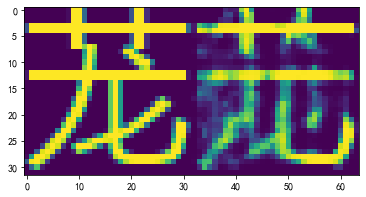

In [48]:
hanzi_X = dataset.__getitem__(random.randint(0, len(dataset)))
hanzi_Y = model(hanzi_X.unsqueeze(0))[0].detach()
plt.imshow(torch.concat([hanzi_X, hanzi_Y], dim=1).detach().numpy())

In [49]:
torch.save(model.encoder, "glyph_dense_encoder.pt")

In [127]:
model.encoder

Sequential(
  (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))
  (7): Sigmoid()
  (8): Flatten(start_dim=1, end_dim=-1)
)